# Integration (iRECODE)

We demonstrate RECODE integration for scRNA-seq data produced by 10X Chromium. We use scRNA-seq datasets encompassing three batches and two cell lines (HEK293T and Jurkat). The test data is directly available from GitHub page of [JinmiaoChenLab](https://github.com/JinmiaoChenLab/Batch-effect-removal-benchmarking/tree/master/Data/dataset6).
All data can be downloaded by "git clone https://github.com/JinmiaoChenLab/Batch-effect-removal-benchmarking.git"

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [ ]:
#pip install screcode harmonypy anndata

In [4]:
import screcode
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import sklearn
import warnings
warnings.simplefilter('ignore')

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [5]:
input_dir = 'Batch-effect-removal-benchmarking/Data/dataset6'
input_dir = 'data/dataset6'
input_filenames = ['b1_exprs','b2_exprs','b3_exprs']
input_filenames_meta = ['b1_celltype','b2_celltype','b3_celltype']

data_input = pd.concat([pd.read_csv('%s/%s.txt.gz' % (input_dir,file),index_col=0,delimiter='\t').T for file in input_filenames])
data_input_meta = pd.DataFrame()
for i in range(len(input_filenames)):
    df_ = pd.read_csv('%s/%s.txt.gz' % (input_dir,input_filenames_meta[i]),index_col=0,delimiter='\t')
    df_["batch"] = np.full(len(df_.index),input_filenames[i],dtype=object)
    data_input_meta = pd.concat([data_input_meta,df_])
adata = anndata.AnnData(X=data_input,obs=data_input_meta)
adata = adata[:,np.sum(adata.X,axis=0)>0]
adata.layers["Raw"] = adata.X
adata

AnnData object with n_obs × n_vars = 9531 × 21474
    obs: 'CellType', 'batch'
    layers: 'Raw'

## Apply iRECODE
Apply RECODE integration to the count matrix. The **anndata** or **ndarray** data formats are available.  If your data format is ndarray, prepare meta_data including batch infromation by DataFrame format.

In [6]:
recode = screcode.RECODE()
adata = recode.fit_transform_integration(adata)

start RECODE integration for scRNA-seq data


2025-11-21 19:16:17,925 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-21 19:16:20,070 - harmonypy - INFO - sklearn.KMeans initialization complete.


end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': np.int64(14462), '#non-significant genes': np.int64(7012), '#silent genes': np.int64(0), 'ell': np.int64(154), 'Elapsed time': '0h 0m 38s 052ms', 'solver': 'full'}


In [7]:
## Case of ndarray format
## data: single-cell count matrix [ndarray], meta_data: meta data including batch labels [DataFrame]
# recode = screcode.RECODE()
# data_RECODE = recode.fit_transform_integration(data, meta_data=meta_data, batch_key="batch")

With anndata format, outputs of RECODE are included in anndata objects:
- denoised matrix -> adata.obsm['RECODE']
- noise variance -> adata.var['noise_variance_RECODE']
- normalized variance (NVSN variance) ->  adata.var['normalized_variance_RECODE']
- clasification of genes (significant/non-significant/silent) ->  adata.var['significance_RECODE']

### Performance check

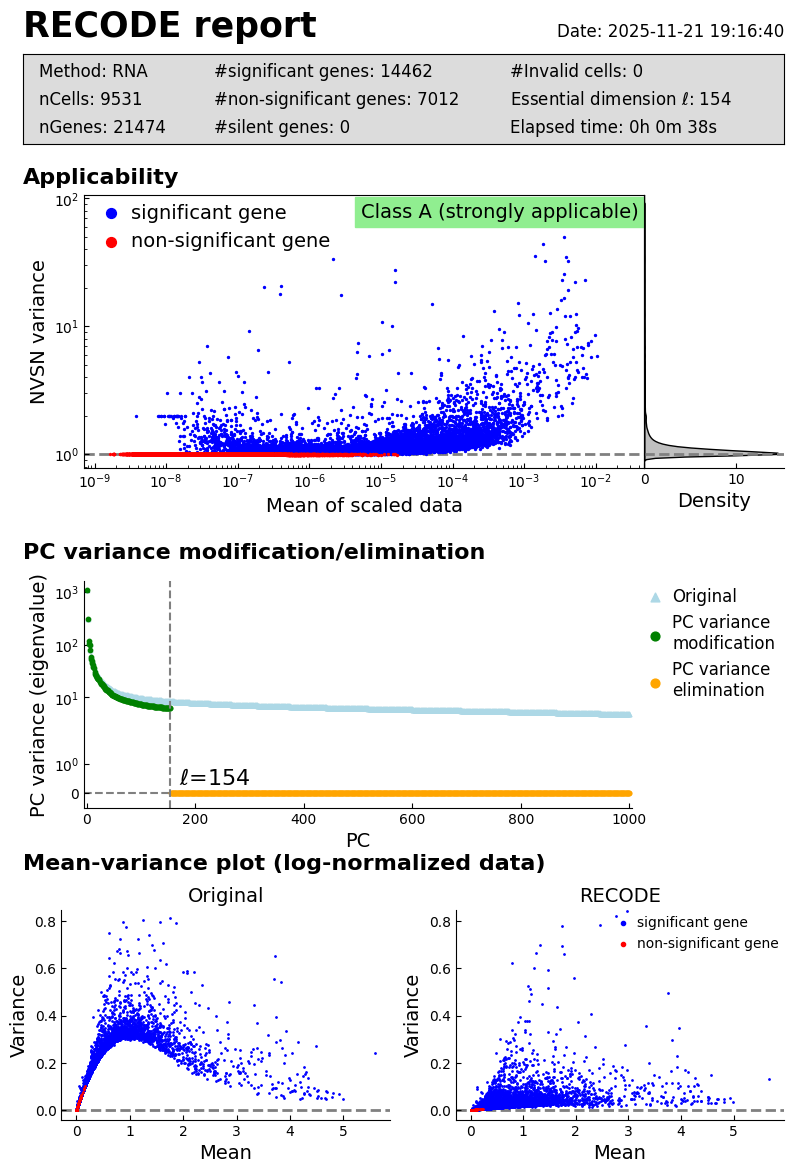

In [8]:
recode.report()

## Downstream analysis

### log normalization

In [9]:
target_sum = 1e4

adata.layers["Raw_log"] = np.log(target_sum*adata.layers["Raw"]/np.sum(adata.layers["Raw"],axis=1)[:,np.newaxis]+1)
adata.layers["RECODE_log"] = np.log(target_sum*adata.layers["RECODE"]/np.sum(adata.layers["RECODE"],axis=1)[:,np.newaxis]+1)

### PCA

In [10]:
n_components = 50
adata.obsm["Raw_PCA"] = sklearn.decomposition.PCA(n_components=n_components).fit_transform(adata.layers["Raw_log"])
adata.obsm["RECODE_PCA"] = sklearn.decomposition.PCA(n_components=n_components).fit_transform(adata.layers["RECODE_log"])

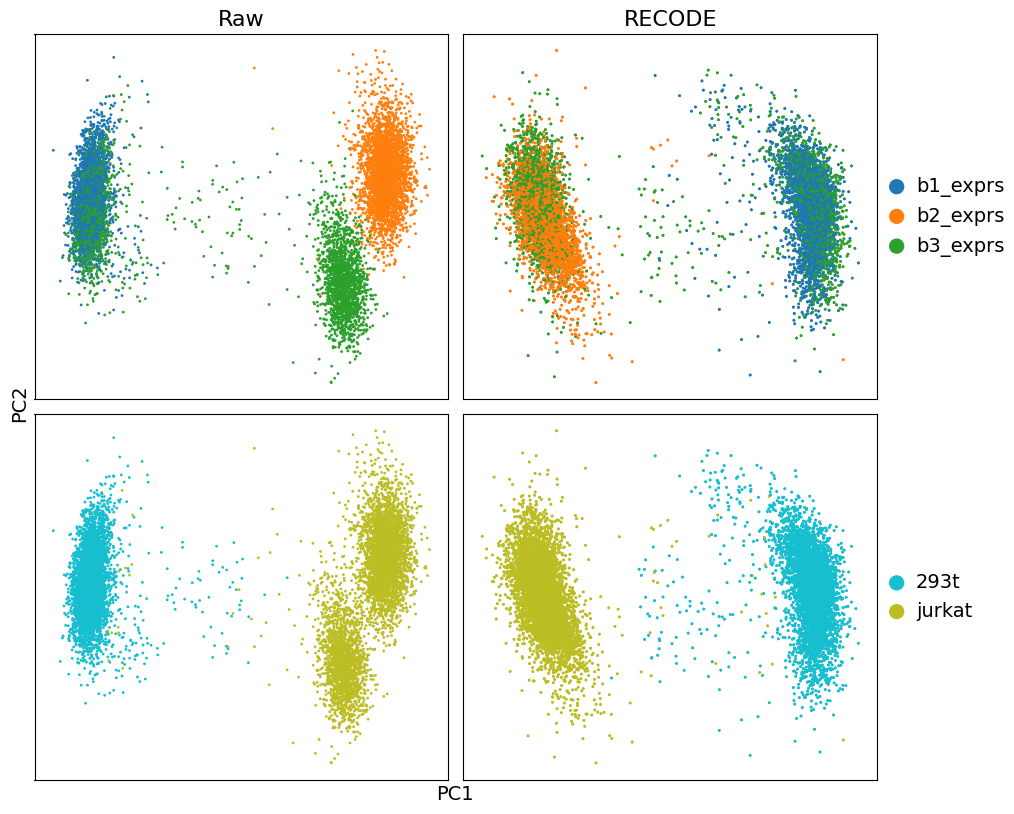

In [11]:
import matplotlib
import matplotlib.pyplot as plt

def plot_2d(
    adata,
    data_lables = ["Raw", "RECODE"],
    data_type = "PCA",
    color_labels = ['batch','CellType'],
    fig_size = 4,
    fs_title = 16,
    fs_label = 14,
    fs_legend = 14,
    labels = ["PC1","PC2"],
    cmaps = ["tab10","tab10_r"],
    vmaxs = [10,10]
    ):
    fig,ax = plt.subplots(2,2,figsize=((len(data_lables)+0.5)*fig_size,len(color_labels)*fig_size),tight_layout=True)
    for i in range(len(color_labels)):
        colors = np.copy(adata.obs[color_labels[i]].values)
        color_set = np.unique(colors)
        colors_num = np.copy(colors)
        [np.place(colors_num,colors_num==color_set[i],i) for i in range(len(color_set))]
        for j in range(len(data_lables)):
            ax_ = ax[i,j]
            name_  = data_lables[j] + "_" + data_type
            plot_data = adata.obsm[name_]
            idx_rdm_ = np.random.permutation(plot_data.shape[0])
            ax_.scatter(plot_data[idx_rdm_,0],plot_data[idx_rdm_,1],c=colors_num[idx_rdm_],s=1,cmap=cmaps[i],vmax=vmaxs[i],zorder=100)
            ax_.tick_params(bottom=False, left=False, right=False, top=False, labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            if j==len(data_lables)-1:
                for c_ in np.unique(colors):
                    idx_ = colors == c_
                    ax_.scatter(plot_data[idx_,0],plot_data[idx_,1],c=colors_num[idx_],s=1,cmap=cmaps[i],vmin=0,vmax=vmaxs[i],label=c_,zorder=0)
                    ax_.legend(bbox_to_anchor=(1.0,0.5), loc="center left", borderaxespad=0, fontsize=fs_legend,markerscale=10,ncol=1,frameon=False,handletextpad=0.,borderpad=0)
            if i == 0:
                ax_.set_title(data_lables[j],fontsize=fs_title)
    plt.gcf().text(0.435,0.0,labels[0], ha="center",va="center",fontsize=fs_label)
    plt.gcf().text(0.0,0.49,labels[1], ha="center",va="center",rotation=90, fontsize=fs_label)


plot_2d(
    adata,
    data_lables = ["Raw", "RECODE"],
    data_type = "PCA",
    color_labels = ['batch','CellType'],
    labels = ["PC1","PC2"]
)

### UMAP

In [12]:
import umap
n_components = 2
adata.obsm["Raw_UMAP"] = umap.UMAP(n_components=n_components).fit_transform(adata.obsm["Raw_PCA"])
adata.obsm["RECODE_UMAP"] = umap.UMAP(n_components=n_components).fit_transform(adata.obsm["RECODE_PCA"])

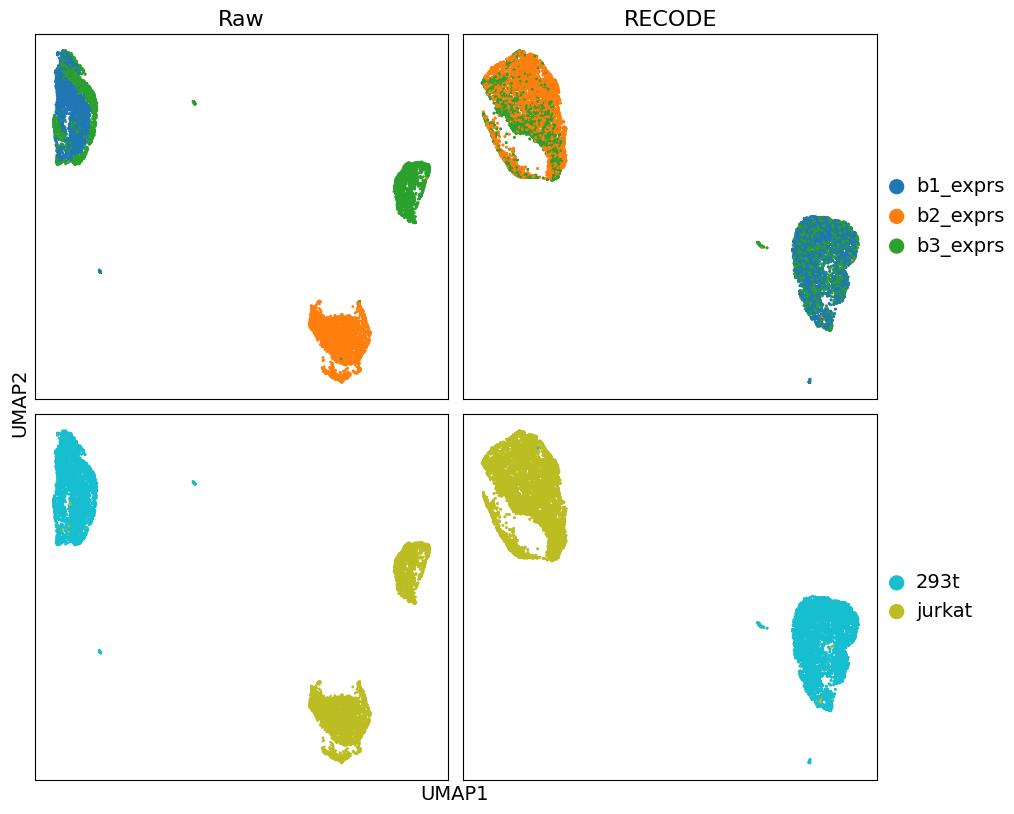

In [13]:
plot_2d(
    adata,
    data_lables = ["Raw", "RECODE"],
    data_type = "UMAP",
    color_labels = ['batch','CellType'],
    labels = ["UMAP1","UMAP2"]
)

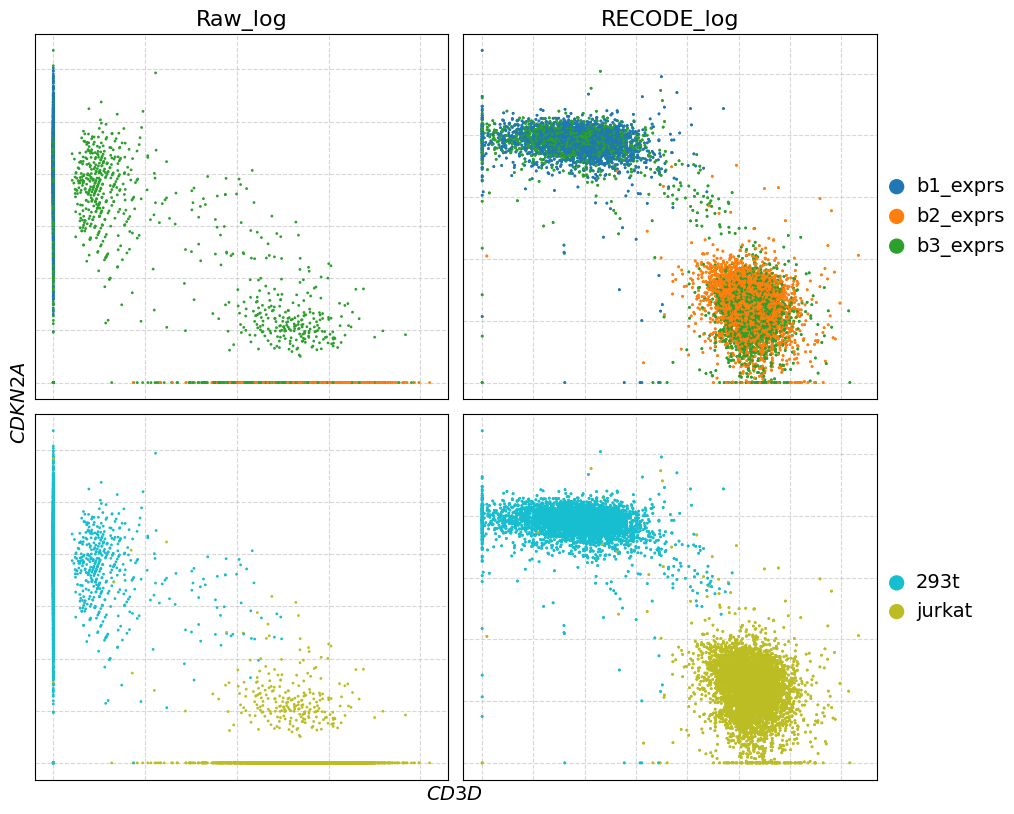

In [14]:
def plot_gex(
    adata,
    genes,
    data_lables = ["Raw_log", "RECODE_log"],
    color_labels = ['batch','CellType'],
    fig_size = 4,
    fs_title = 16,
    fs_label = 14,
    fs_legend = 14,
    cmaps = ["tab10","tab10_r"],
    vmaxs = [10,10]
    ):
    for gene_ in genes:
        fig,ax = plt.subplots(2,len(data_lables),figsize=((len(data_lables)+0.5)*fig_size,len(color_labels)*fig_size),tight_layout=True)
        for i in range(len(color_labels)):
            colors = np.copy(adata.obs[color_labels[i]].values)
            color_set = np.unique(colors)
            colors_num = np.copy(colors)
            [np.place(colors_num,colors_num==color_set[i],i) for i in range(len(color_set))]
            for j in range(len(data_lables)):
                ax_ = ax[i,j]
                name_  = data_lables[j]
                plot_data = adata.layers[name_]
                idx_x_ = adata.var.index == gene_[0]
                idx_y_ = adata.var.index == gene_[1]
                idx_rdm_ = np.random.permutation(plot_data.shape[0])
                ax_.scatter(plot_data[idx_rdm_][:,idx_x_],plot_data[idx_rdm_][:,idx_y_],c=colors_num[idx_rdm_],s=1,cmap=cmaps[i],vmax=vmaxs[i],zorder=100)
                ax_.tick_params(bottom=False, left=False, right=False, top=False, labelbottom=False, labelleft=False, labelright=False, labeltop=False)
                if j==len(data_lables)-1:
                    for c_ in np.unique(colors):
                        idx_ = colors == c_
                        ax_.scatter(plot_data[idx_][:,idx_x_],plot_data[idx_][:,idx_y_],c=colors_num[idx_],s=1,cmap=cmaps[i],vmin=0,vmax=vmaxs[i],label=c_,zorder=0)
                        ax_.legend(bbox_to_anchor=(1.0,0.5), loc="center left", borderaxespad=0, fontsize=fs_legend,markerscale=10,ncol=1,frameon=False,handletextpad=0.,borderpad=0)
                if i == 0:
                    ax_.set_title(data_lables[j],fontsize=fs_title)
                ax_.grid(ls="--",alpha=0.5,zorder=0)
        plt.gcf().text(0.435,0.0,"$\it{%s}$" % gene_[0], ha="center", va="center", fontsize=fs_label)
        plt.gcf().text(0.0,0.490,"$\it{%s}$" % gene_[1], ha="center", va="center", fontsize=fs_label,rotation=90)

genes = [["CD3D", "CDKN2A"]]
plot_gex(adata,genes)

## Adjust parameters of batch correction

In [15]:
recode = screcode.RECODE(RECODE_key="RECODE_theta")
adata = recode.fit_transform_integration(adata,integration_method_params = {"theta":0.1})

start RECODE integration for scRNA-seq data


2025-11-21 19:17:50,808 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-21 19:17:52,928 - harmonypy - INFO - sklearn.KMeans initialization complete.


end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': np.int64(14462), '#non-significant genes': np.int64(7012), '#silent genes': np.int64(0), 'ell': np.int64(154), 'Elapsed time': '0h 0m 39s 513ms', 'solver': 'full'}


In [16]:
adata = recode.lognormalize(adata,key="RECODE_theta")

Normalized data are stored in "RECODE_theta_norm" and "RECODE_theta_log"


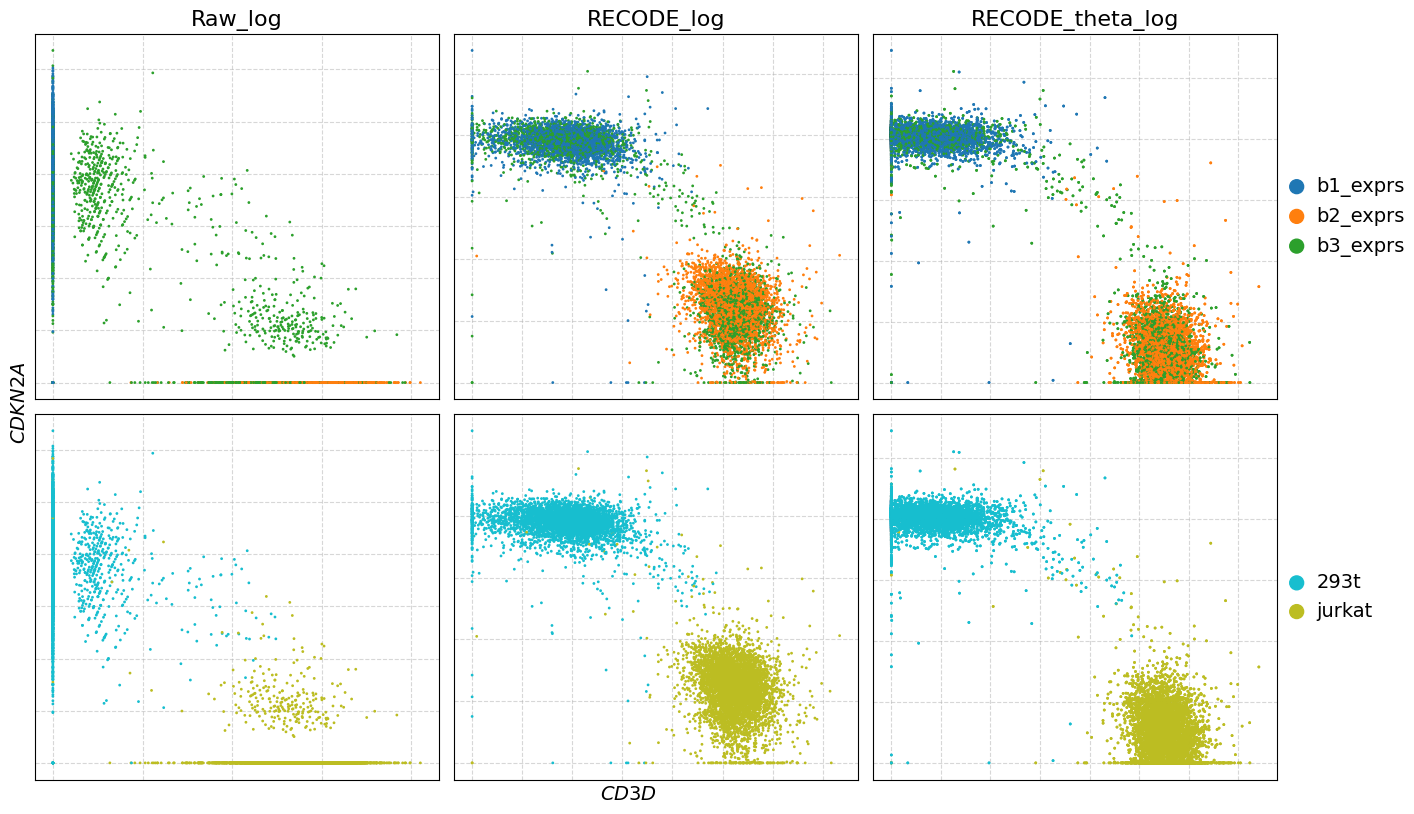

In [17]:
genes = [["CD3D", "CDKN2A"]] 
plot_gex(adata,genes,data_lables = ["Raw_log", "RECODE_log", "RECODE_theta_log"])